In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
sns.set_palette(flatui) 
sns.set(font_scale = 2)

from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [2]:
dockless_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Dockless_Vehicle_Trips.csv")
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")
# Call the dockless_data_pipeline()
dockless_data = dockless_data_pipeline(dockless_data)
dockless_vehicles_columns = dockless_data.columns
print_eda_stats(dockless_data, dockless_vehicles_columns, "Austin Dockless Mobility Data")


/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


+--------------------------+---------+-------------+---------------+--------------+-------------------+
|       Column Name        |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+--------------------------+---------+-------------+---------------+--------------+-------------------+
|            ID            |  object |   2746505   |    2746505    |   2746505    |         0         |
|        Device ID         |  object |   2746505   |     26999     |   2746505    |         0         |
|       Vehicle Type       |  object |   2746504   |       3       |   2746505    |         1         |
|      Trip Duration       | float64 |   2746504   |     10521     |   2746505    |         1         |
|      Trip Distance       | float64 |   2746504   |     16125     |   2746505    |         1         |
|        Start Time        |  object |   2746504   |     25694     |   2746505    |         1         |
|         End Time         |  object |   2746504   |     25768  

In [3]:
#Read the weather data from S3 bucket
weather_data = pd.read_csv("https://s3.amazonaws.com/sameera-bucket-1/dockless_mobility/raw_data/Austin_Bergstom_Airport_Weather.csv")
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")
weather_data = weather_data_pipeline(weather_data)
weather_columns = weather_data.columns
print_eda_stats(weather_data, weather_columns, "Austin Weather Data")

+-----------------+---------+-------------+---------------+--------------+-------------------+
|   Column Name   |  dtype  | Total_Count | Unique_Values | df_totalrows | Null Value counts |
+-----------------+---------+-------------+---------------+--------------+-------------------+
|     STATION     |  object |     436     |       1       |     436      |         0         |
|       NAME      |  object |     436     |       1       |     436      |         0         |
|     LATITUDE    | float64 |     436     |       1       |     436      |         0         |
|    LONGITUDE    | float64 |     436     |       1       |     436      |         0         |
|    ELEVATION    | float64 |     436     |       1       |     436      |         0         |
|       DATE      |  object |     436     |      436      |     436      |         0         |
|       AWND      | float64 |     435     |       73      |     436      |         1         |
| AWND_ATTRIBUTES |  object |     435     |       

In [4]:
# Plot the distribution of distances 

trip_distance_value_count = dockless_data['Trip Distance'].value_counts()
trip_distance_value_count = trip_distance_value_count.sort_values(ascending=False)



In [5]:
trip_duration_value_count = dockless_data['Trip Duration'].value_counts()
trip_duration_value_count = trip_duration_value_count.sort_values(ascending=False)

In [6]:
dockless_data['Trip Duration'].max()

1888695.0

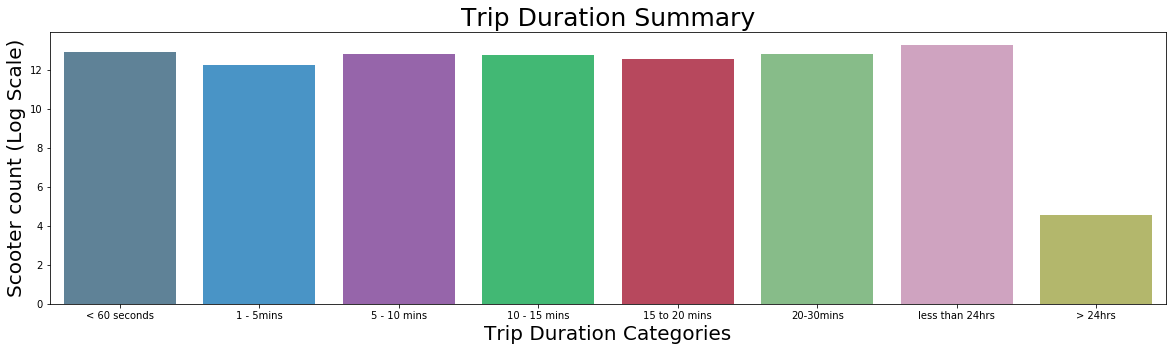

In [25]:
# dockless_data['Trip Duration'].max() -- 1888695.0
dd = pd.DataFrame({'trip_duration':trip_distance_value_count.index, 'count':trip_distance_value_count.values})

bins = [-431.0, 60, 300, 600,900, 1200, 1800, 86400, 1888695]
labels = ['< 60 seconds', '1 - 5mins','5 - 10 mins' ,'10 - 15 mins', '15 to 20 mins', '20-30mins', 'less than 24hrs', '> 24hrs']
dd['category_classes'] = pd.cut(dd['trip_duration'], bins=bins, labels=labels,include_lowest=True, right=True)
prob_groups = dd.groupby(['category_classes'])['count'].sum()

prob_groups_log = np.log(prob_groups)

plt.figure(figsize=(20,5))

# sns.barplot(x=prob_groups.index, y=prob_groups.values)
# plt.title('Trip Duration Summary', fontsize=25)
# plt.ylabel('Scooter count', fontsize=20)
# plt.xlabel('Trip Duration Categories', fontsize=20)
# plt.savefig('../../output/Final/Trip_Duration_Summary.png')

sns.barplot(x=prob_groups_log.index, y=prob_groups_log.values)
plt.title('Trip Duration Summary', fontsize=25)
plt.ylabel('Scooter count (Log Scale)', fontsize=20)
plt.xlabel('Trip Duration Categories', fontsize=20)
plt.savefig('../../output/Final/Trip_Duration__Log_Summary.png')

plt.show()

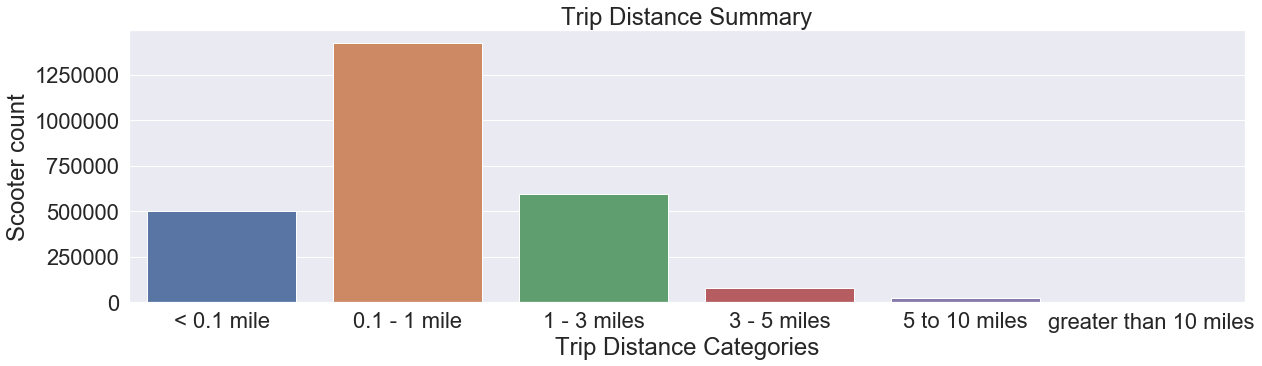

In [27]:
sns.set(font_scale = 2)
dd = pd.DataFrame({'trip_distance':trip_distance_value_count.index, 'count':trip_distance_value_count.values})

bins2 = [-16724106.0, 161, 1601, 4828,8047, 16093, 804672]
labels2 = ['< 0.1 mile', '0.1 - 1 mile','1 - 3 miles' ,'3 - 5 miles', '5 to 10 miles', 'greater than 10 miles']
dd['category_classes'] = pd.cut(dd['trip_distance'], bins=bins2, labels=labels2, include_lowest=True, right=True)

prob_groups = dd.groupby(['category_classes'])['count'].sum()

prob_groups_log = np.log(prob_groups)

plt.figure(figsize=(20,5))

sns.barplot(x=prob_groups.index, y=prob_groups.values)
plt.title('Trip Distance Summary')
plt.ylabel('Scooter count')
plt.xlabel('Trip Distance Categories')
plt.savefig('../../output/Final/Trip_Distance_Summary.png')

# sns.barplot(x=prob_groups_log.index, y=prob_groups_log.values)
# plt.title('Trip Distance Summary')
# plt.ylabel('Scooter count (Log Scale)', fontsize=12)
# plt.xlabel('Trip Distance Categories', fontsize=12)
# plt.savefig('../../output/Final/Trip_Distance_Logarithmic_Summary.png')

plt.show()


In [11]:
# TODO : Add to pipeline
# Drop all records where  trip distance is less .1 miles and greater than 500 miles (160.934 mts - 804673 mts)
dockless_data = dockless_data[(dockless_data['Trip Distance'] > 160.934) & (dockless_data['Trip Distance'] < 804673)]
dockless_data = dockless_data[(dockless_data['Trip Duration'] > 60) & (dockless_data['Trip Duration'] < 86400)]

In [12]:
# TODO : Add to pipeline
# Have only weather data which is from the start date of the scooter data
trip_counts = dockless_data.groupby('START_DATE').count()['count']
weather_data= weather_data[weather_data['DATE'] >= trip_counts.index.min()]
weather_data= weather_data[weather_data['DATE'] <= trip_counts.index.max()]


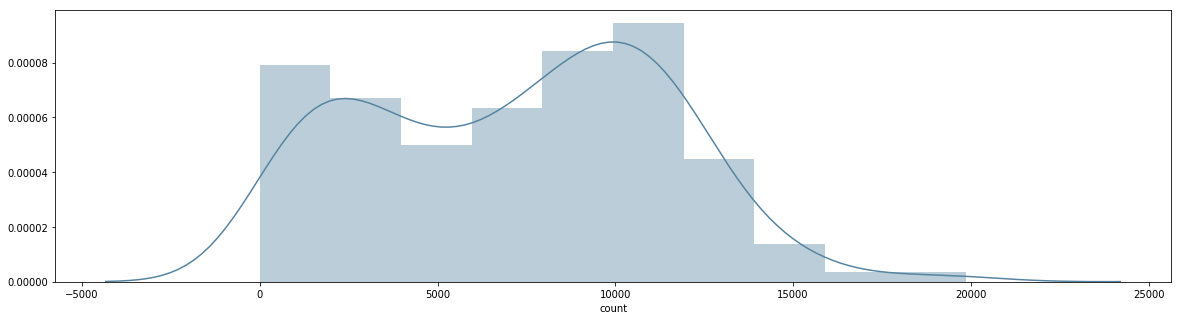

In [14]:
plt.figure(figsize=(20,5))
sns.distplot(trip_counts);
plt.show()

# plt.title('Destination Cell Counts - Top 50')
# plt.ylabel('Number of Occurrences', fontsize=12)
# plt.xlabel('Destination Cell ID', fontsize=12,rotation='horizontal')
# plt.xticks(rotation=90)
# plt.savefig('../output/EDA/Destination_Cell_Counts_Top_50.png')
# plt.show()

In [15]:
hourly = dockless_data.resample('H').sum()


In [16]:
total_trip_counts = dockless_data.groupby('Start Time').count()['count']

In [17]:
total_trip_counts.head(5)

Start Time
2018-04-03 18:30:00    1
2018-04-04 15:45:00    1
2018-04-04 17:15:00    1
2018-04-05 05:00:00    1
2018-04-05 08:30:00    2
Name: count, dtype: int64

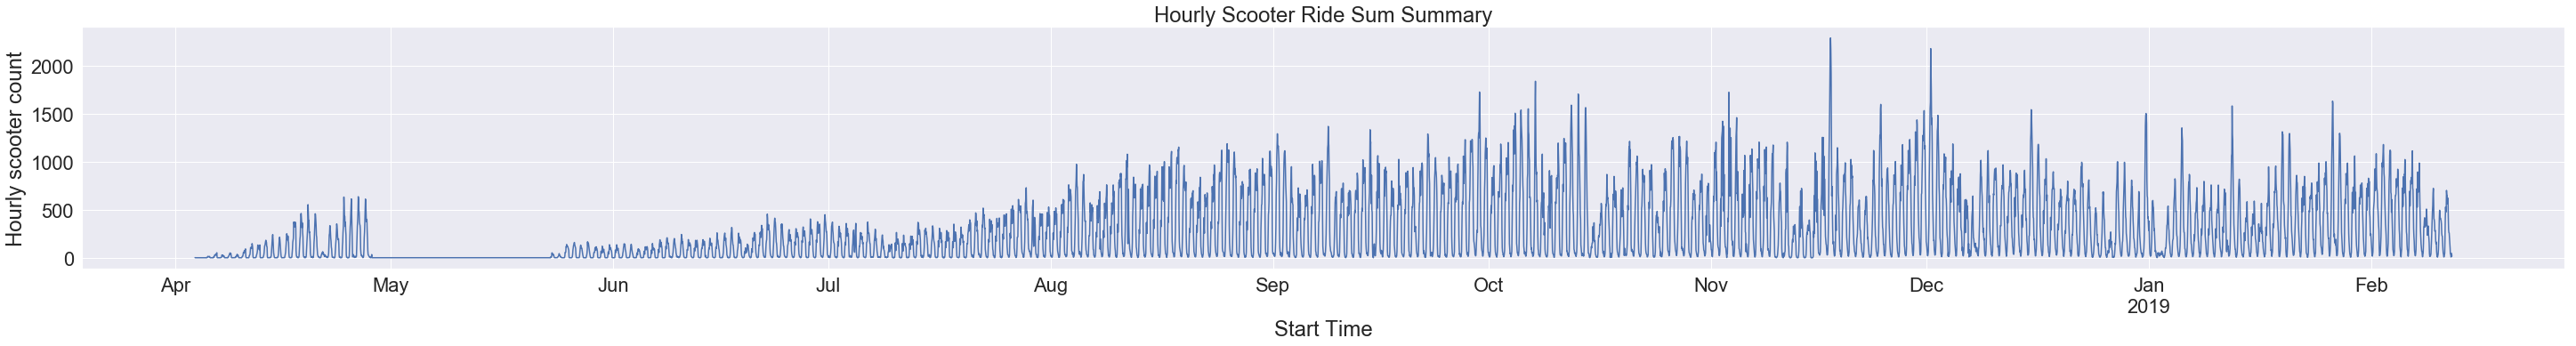

In [28]:
hourly = total_trip_counts.resample('H').sum()
hourly.plot(style=['-', '--', ':'],figsize=(50, 5))
plt.title('Hourly Scooter Ride Sum Summary')
plt.ylabel('Hourly scooter count')
plt.savefig('../../output/EDA/Top/Hourly_Scooter_Total_expanded.png')

In [19]:
hourly.max()

2289

In [20]:
hourly[hourly==(hourly.max())]

Start Time
2018-11-17 16:00:00    2289
Freq: H, Name: count, dtype: int64

In [21]:
hourly.sort_values(ascending=False)

Start Time
2018-11-17 16:00:00    2289
2018-11-17 15:00:00    2233
2018-12-01 15:00:00    2178
2018-11-17 17:00:00    2166
2018-12-01 16:00:00    1963
2018-11-17 18:00:00    1917
2018-11-17 14:00:00    1896
2018-10-07 13:00:00    1838
2018-12-01 17:00:00    1740
2018-09-29 18:00:00    1726
2018-11-03 12:00:00    1723
2018-10-13 12:00:00    1705
2018-10-13 13:00:00    1691
2018-09-29 19:00:00    1651
2018-10-07 12:00:00    1644
2019-01-26 15:00:00    1631
2018-12-01 14:00:00    1620
2019-01-26 16:00:00    1606
2018-11-24 16:00:00    1597
2018-10-12 13:00:00    1589
2019-01-12 15:00:00    1581
2018-10-14 13:00:00    1564
2018-11-17 13:00:00    1562
2018-12-01 13:00:00    1553
2018-11-24 15:00:00    1553
2018-10-06 13:00:00    1551
2018-10-14 12:00:00    1550
2018-12-15 15:00:00    1542
2018-10-05 13:00:00    1539
2018-11-30 17:00:00    1532
                       ... 
2018-05-01 12:00:00       0
2018-05-01 13:00:00       0
2018-05-02 16:00:00       0
2018-05-02 15:00:00       0
2018-05-0

In [23]:
daily = total_trip_counts.resample('D').sum()

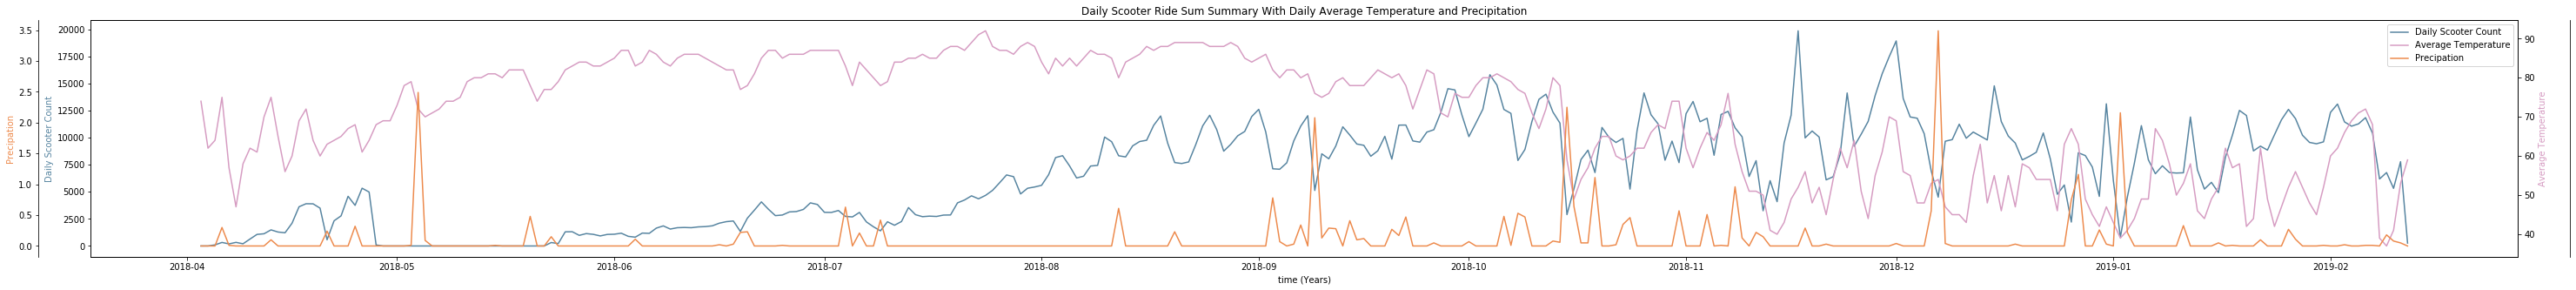

In [24]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

#host = host_subplot(111, axes_class=AA.Axes)

#fig, host = plt.subplots(nrows=1, ncols=1,figsize=(50, 5))

fig, ax = plt.subplots(figsize=(50,5))


#plt.subplots_adjust(right=0.75)
#ax = ax.flatten()
par1 = ax.twinx()
par2 = ax.twinx()

offset = 60



color1 = "#5684A0"
color2 = "#D69CC2"
color3 = "#ED8A4C"


flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
#sns.palplot(sns.color_palette(flatui))
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.palplot(sns.color_palette(flatui))


'''
p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1,label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

'''


ax.set_ylabel("Daily Scooter Count")
par1.set_ylabel("Temperature")
par2.set_ylabel("Precipation")

par2.spines['left'].set_position(('outward', 60)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = ax.plot(daily.index, daily.values, color=color1, label="Daily Scooter Count")
p2, = par1.plot(weather_data.DATE, weather_data.AVG_TEMPERATURE.values,color=color2, label="Average Temperature")
p3, = par2.plot(weather_data.DATE, weather_data.PRECIPITATION.values,color=color3,  label="Precipation")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')


# ax.legend()

par2.spines['right'].set_position(('outward', 60)) 
# no x-ticks                 
#par2.xaxis.set_ticks([])
ax.set_ylabel('Daily Scooter Count', color=color1)
par1.set_ylabel('Average Temperature', color=color2)
par2.set_ylabel('Precipation', color=color3)

plt.title('Daily Scooter Ride Sum Summary With Daily Average Temperature and Precipitation')
ax.set_xlabel('time (Years)')
# ax.axis["left"].label.set_color(color2)
# par1.axis["right"].label.set_color(color1)
# par2.axis["right"].label.set_color(color3)

#monthly_mean.plot(x=df.index, y='A')
plt.savefig("../../output/EDA/Total_Sccoter_Temp_Precip.png")
plt.show()

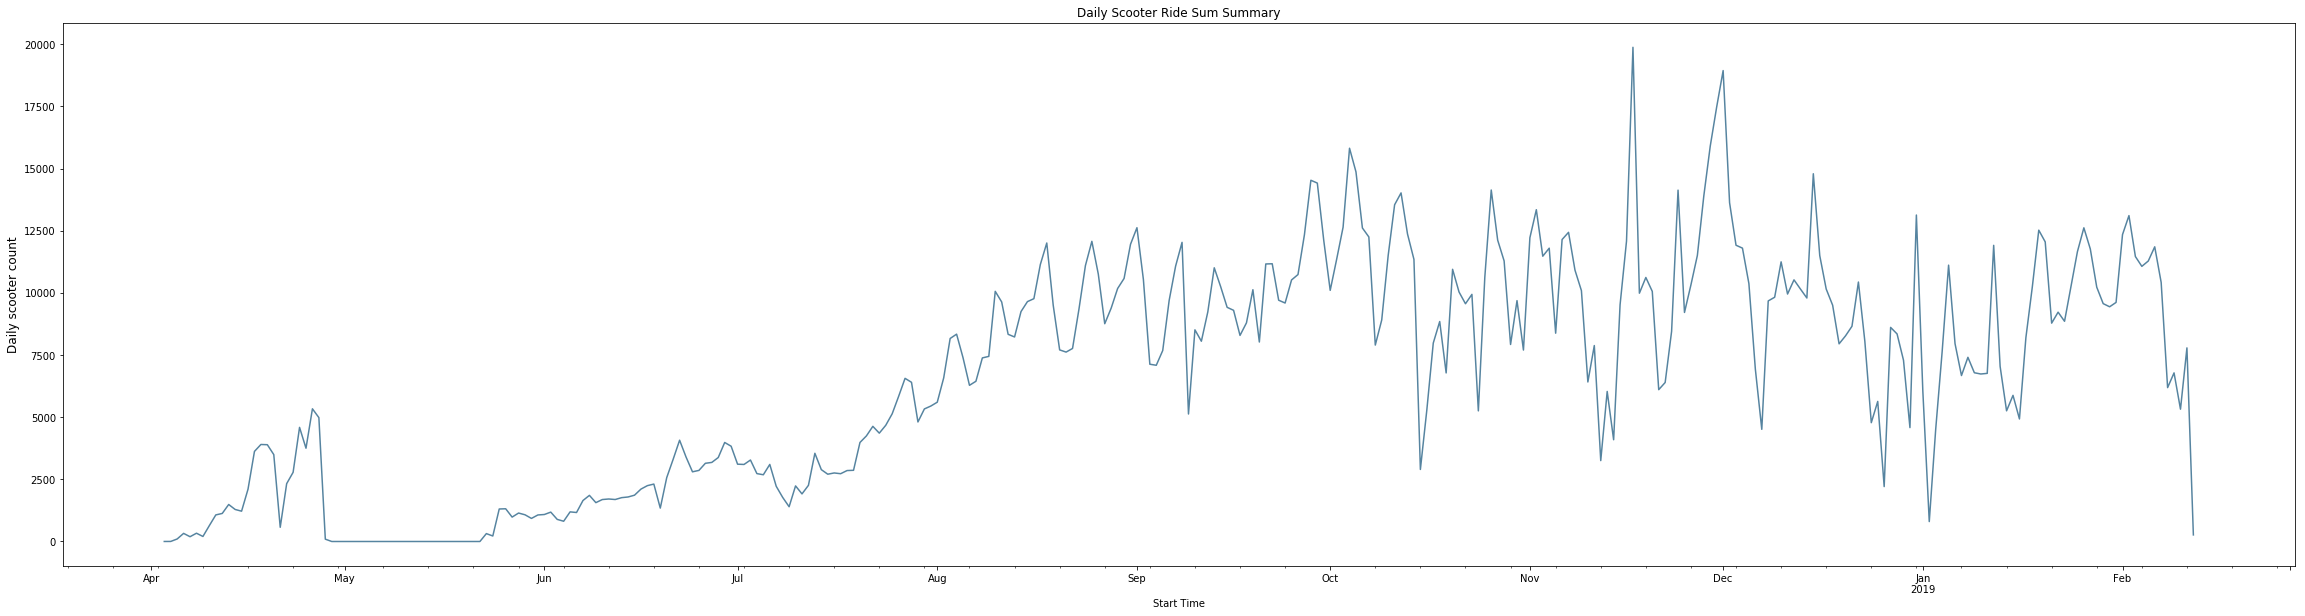

In [137]:
daily = total_trip_counts.resample('D').sum()
daily.plot(style=['-', '--', ':'],figsize=(40, 10))
plt.title('Daily Scooter Ride Sum Summary')
plt.ylabel('Daily scooter count', fontsize=12)
plt.savefig('../../output/EDA/Top/D_Scooter_Total_expanded.png')

In [141]:
daily.sort_values(ascending=False)

Start Time
2018-11-17    19874
2018-12-01    18938
2018-11-30    17479
2018-11-29    15902
2018-10-04    15815
2018-10-05    14865
2018-12-15    14789
2018-09-28    14527
2018-09-29    14414
2018-10-26    14135
2018-11-24    14130
2018-10-12    14019
2018-11-28    13898
2018-12-02    13624
2018-10-11    13542
2018-11-02    13343
2018-12-31    13129
2019-02-02    13106
2018-10-03    12639
2018-09-01    12619
2019-01-26    12615
2018-10-06    12608
2019-01-19    12520
2018-11-07    12433
2018-10-13    12368
2019-02-01    12342
2018-09-27    12338
2018-10-07    12247
2018-11-01    12216
2018-11-06    12144
              ...  
2018-04-09      202
2018-04-07      192
2018-04-05      101
2018-04-28       94
2018-04-04        2
2018-04-03        1
2018-05-14        1
2018-05-22        0
2018-05-21        0
2018-05-20        0
2018-05-19        0
2018-05-18        0
2018-05-17        0
2018-05-16        0
2018-05-15        0
2018-05-03        0
2018-05-02        0
2018-05-12        0
2018-05-1

In [52]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

#host = host_subplot(111, axes_class=AA.Axes)

#fig, host = plt.subplots(nrows=1, ncols=1,figsize=(50, 5))

fig, ax = plt.subplots(figsize=(50,5))


#plt.subplots_adjust(right=0.75)
#ax = ax.flatten()
par1 = ax.twinx()
par2 = ax.twinx()

offset = 60



color1 = "#5684A0"
color2 = "#D69CC2"
color3 = "#ED8A4C"


flatui = ["#5684A0", "#3498db","#9b59b6","#2ecc71" ,"#C93551", "#7EC581", "#D69CC2", "#BEC45F","#FCC38E", "#ED8A4C", "#997474","#8B878D"]
#sns.palplot(sns.color_palette(flatui))
# flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# sns.palplot(sns.color_palette(flatui))


'''
p1, = host.plot([0, 1, 2], [0, 1, 2], color=color1,label="Density")
p2, = par1.plot([0, 1, 2], [0, 3, 2], color=color2, label="Temperature")
p3, = par2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))      
# no x-ticks                 
par2.xaxis.set_ticks([])
# Sometimes handy, same for xaxis
#par2.yaxis.set_ticks_position('right')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

'''


ax.set_ylabel("Daily Scooter Count")
par1.set_ylabel("Temperature")
par2.set_ylabel("Precipation")

par2.spines['left'].set_position(('outward', 60)) 
par2.spines["left"].set_visible(True) 
par2.yaxis.set_label_position('left') 
par2.yaxis.set_ticks_position('left')

p1, = ax.plot(daily.index, y1, color=color1, label="Daily Scooter Count")
p2, = par1.plot(weather_data.DATE, weather_data.AVG_TEMPERATURE.values,color=color2, label="Average Temperature")
p3, = par2.plot(weather_data.DATE, weather_data.PRECIPITATION.values,color=color3,  label="Precipation")

lns = [p1, p2, p3]
ax.legend(handles=lns, loc='best')


# ax.legend()

par2.spines['right'].set_position(('outward', 60)) 
# no x-ticks                 
#par2.xaxis.set_ticks([])
ax.set_ylabel('Daily Scooter Count', color=color1)
par1.set_ylabel('Average Temperature', color=color2)
par2.set_ylabel('Precipation', color=color3)

plt.title('Daily Scooter Ride Sum Summary With Daily Average Temperature and Precipitation')
ax.set_xlabel('time (Years)')
# ax.axis["left"].label.set_color(color2)
# par1.axis["right"].label.set_color(color1)
# par2.axis["right"].label.set_color(color3)

#monthly_mean.plot(x=df.index, y='A')
plt.savefig("../../output/EDA/Total_Sccoter_Temp_Precip.png")
plt.show()

#### Univariate Time Series 

In [29]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title("Dockless Scooter Trend For {}".format(name))

def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)
    
def fit_moving_average_trend(series, window=6):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Moving Average Trend For {}".format(name))
    ax.plot(series.index, moving_average_trend)
    
def create_monthly_dummies(series):
    month = series.index.month
    # Only take 11 of the 12 dummies to avoid strict colinearity.
    return pd.get_dummies(month).ix[:, :11]

def fit_seasonal_trend(series):
    dummies = create_monthly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    seasonal_model = sm.OLS(series.values, X).fit()
    return seasonal_model.predict(X)

def plot_seasonal_trend(ax, name, series):
    seasons_average_trend = fit_seasonal_trend(series)
    plot_trend_data(ax, name, series)
    ax.set_title("Dockless Scooter Seasonality Trend For {}".format(name))
    ax.plot(series.index, seasons_average_trend)
    
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")
    
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))
    
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

def format_list_of_floats(L):
    return ["{0:2.2f}".format(f) for f in L]